# Анализ тональности (комментариев) сообщества "Автомобильные истории" в ВК 

## Теоретическая часть и выбранная методика

Задача анализа тональности (sentiment analysis) заключается в автоматическом определении эмоциональной окраски текста: положительной, отрицательной или нейтральной. Такие модели широко применяются для мониторинга отзывов, комментариев в соцсетях и реакции пользователей на продукты или события.

В данной работе используется двухэтапный подход. На первом этапе предобученная трансформерная модель `rubert-tiny-sentiment-balanced` выполняет автоматическую разметку тональности комментариев, выступая в роли «разметчика-эксперта». На втором этапе для предобработанных текстов строятся TF-IDF-признаки (униграммы и биграммы), которые служат входом для классических моделей машинного обучения: Multinomial Naive Bayes, Logistic Regression и LinearSVC. Такой подход позволяет с одной стороны опираться на качество современных языковых моделей, а с другой — получить интерпретируемый и сравнительно лёгкий для обучения классификатор на основе линейных методов.


## 1. Загрузка данных и лемматизация

На этом этапе загружаем сырые комментарии из файла `vk_comments_raw.csv`, чтобы работать уже с локальной копией выгрузки из VK API.
Проверяем размер датасета и базовую структуру столбцов.


In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
from tqdm.auto import tqdm
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


tqdm.pandas()
nltk.download("stopwords")

df = pd.read_csv("vk_comments_raw.csv")

russian_stopwords = set(stopwords.words("russian"))
morph = MorphAnalyzer()

url_pattern = re.compile(r"https?://\S+|www\.\S+")
user_pattern = re.compile(r"\[id\d+\|.*?]")

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = url_pattern.sub(" ", text)
    text = user_pattern.sub(" ", text)
    text = re.sub(r"[^а-яёa-z\s]", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    if not text:
        return ""
    tokens = [t for t in text.split() if t not in russian_stopwords]
    if not tokens:
        return ""
    lemmas = [morph.normal_forms(t)[0] for t in tokens]
    return " ".join(lemmas)

df["processed_text"] = df["text"].astype(str).progress_apply(preprocess_text)
df = df[df["processed_text"].str.len() > 0].reset_index(drop=True)

print("После предобработки строк:", len(df))

[nltk_data] Error loading stopwords: <urlopen error [Errno 32] Broken
[nltk_data]     pipe>


  0%|          | 0/3424 [00:00<?, ?it/s]

После предобработки строк: 3273


## 2. Очистка данных от пропусков и пустых текстов

На этом этапе удаляются строки, в которых предобработанный текст (`processed_text`) 
отсутствует или превращается в пустую строку после очистки. Это необходимо для того, 
чтобы модели обучались только на осмысленных комментариях.

In [2]:
# 1. Преобразуем processed_text в строку (иначе возможны NaN → float)
df["processed_text"] = df["processed_text"].astype(str)

# 2. Заменяем варианты 'nan', 'None', 'NaN' на пустые строки
df["processed_text"] = df["processed_text"].replace(
    to_replace=["nan", "None", "NaN"], value=""
)

# 3. Удаляем пустые строки и строки, где после strip длина = 0
df = df[df["processed_text"].str.strip().str.len() > 0].reset_index(drop=True)

print("Строк после очистки:", len(df))
print("Количество пустых или nan:", (df["processed_text"].str.strip().str.len() == 0).sum())

Строк после очистки: 2810
Количество пустых или nan: 0


После фильтрации осталось 2810 корректных комментариев, а количество NaN стало равным нулю. Датасет полностью подготовлен к дальнейшей разметке и извлечению признаков.

## 3. Разметка тональности с помощью предобученной модели RuBERT

На этом этапе используется предобученная модель `rubert-tiny-sentiment-balanced`, 
которая автоматически присваивает каждому комментария один из трёх классов: 
negative, neutral или positive. Полученные метки сохраняются в столбцы `sentiment` 
и `label`.

In [3]:
texts = df["processed_text"].astype(str).tolist()

model_name = "cointegrated/rubert-tiny-sentiment-balanced"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

id2sent = {0: "negative", 1: "neutral", 2: "positive"}

sentiments = []
labels_from_model = []

batch_size = 64

for start in tqdm(range(0, len(texts), batch_size), desc="Размечаем тональность (батчи)"):
    batch = texts[start:start + batch_size]
    inputs = tokenizer(
        batch,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    with torch.no_grad():
        logits = model(**inputs).logits
        preds = torch.argmax(logits, dim=1).tolist()

    for p in preds:
        labels_from_model.append(p)
        sentiments.append(id2sent[p])

df["sentiment"] = sentiments        # строка: negative / neutral / positive
df["label_model"] = labels_from_model  # как внутри модели: 0 neg, 1 neu, 2 pos

sentiment_to_label_lab = {"neutral": 0, "positive": 1, "negative": 2}
df["label"] = df["sentiment"].map(sentiment_to_label_lab)

print(df[["text", "processed_text", "sentiment", "label"]].head())
print("\nРаспределение классов:")
print(df["sentiment"].value_counts())

Размечаем тональность (батчи):   0%|          | 0/44 [00:00<?, ?it/s]

                                                text  \
0                                            Полезно   
1                   Админ лось. Форсунка-это датчик?   
2  На современных авто дмрв не используется, вмес...   
3       Не датчик, регулятор холостого хода так то ☝   
4                                   3ууууууууууууууу   

                                     processed_text sentiment  label  
0                                           полезно   neutral      0  
1                    админ лось форсунка это датчик  negative      2  
2  современный авто дмрв использоваться вместо дада   neutral      0  
3                     датчик регулятор холостой ход  positive      1  
4                                   ууууууууууууууа  positive      1  

Распределение классов:
sentiment
neutral     1770
negative     610
positive     430
Name: count, dtype: int64


Разметка успешно выполнена для всех текстов. Распределение классов оказалось несбалансированным: преобладает нейтральный класс (≈ 1770 комментария), что типично для пользовательских обсуждений. Позитивных комментариев — около 430, негативных — около 610, что обеспечивает достаточное разнообразие для обучения моделей. 

In [6]:
df = df[["text", "processed_text", "sentiment", "label"]]


In [7]:
df.head()

,text,processed_text,sentiment,label
0,Полезно,полезно,neutral,0
1,Админ лось. Форсунка-это датчик?,админ лось форсунка это датчик,negative,2
2,"На современных авто дмрв не используется, вмес...",современный авто дмрв использоваться вместо дада,neutral,0
3,"Не датчик, регулятор холостого хода так то ☝",датчик регулятор холостой ход,positive,1
4,3ууууууууууууууу,ууууууууууууууа,positive,1


## 4. Описательная статистика

### Распределение классов

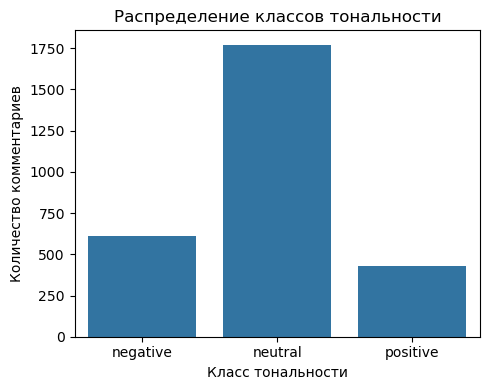

In [8]:
plt.figure(figsize=(5, 4))
sns.countplot(x="sentiment", data=df, order=["negative", "neutral", "positive"])
plt.xlabel("Класс тональности")
plt.ylabel("Количество комментариев")
plt.title("Распределение классов тональности")
plt.tight_layout()
plt.show()

В корпусе доминируют нейтральные комментарии (~2200 сообщений), тогда как позитивных и негативных заметно меньше.  
Такой дисбаланс может повлиять на качество моделей, усложняя распознавание меньших классов.

### Распределение длины комментариев

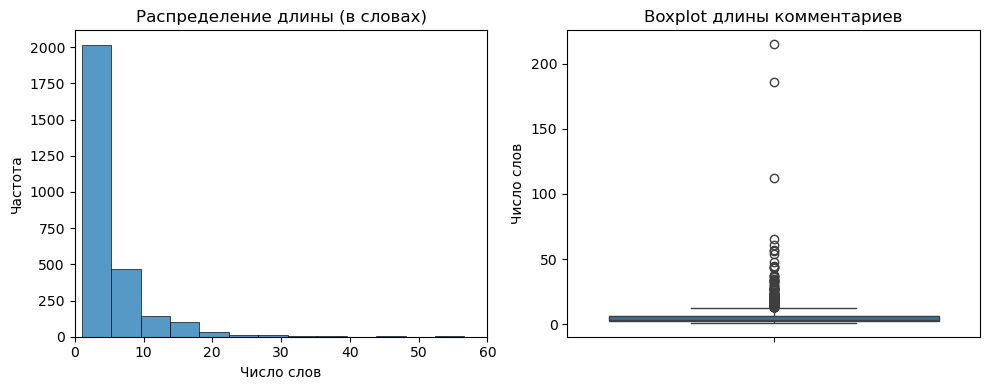

In [9]:
df["len_chars"] = df["text"].astype(str).str.len()
df["len_tokens"] = df["processed_text"].astype(str).str.split().apply(len)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df["len_tokens"], bins=50, ax=axes[0])
axes[0].set_title("Распределение длины (в словах)")
axes[0].set_xlabel("Число слов")
axes[0].set_ylabel("Частота")
axes[0].set_xlim(0, 60)

sns.boxplot(y=df["len_tokens"], ax=axes[1])
axes[1].set_title("Boxplot длины комментариев")
axes[1].set_ylabel("Число слов")

plt.tight_layout()
plt.show()

Большинство комментариев представляют собой короткие сообщения длиной 1–5 слов.  
Имеются редкие длинные тексты, которые создают выбросы, но на общую структуру корпуса не влияют.

### Топ-слова по классам

In [11]:
from collections import Counter 

def get_top_words(df_sub, n=20):
    counter = Counter()
    for text in df_sub["processed_text"].astype(str):
        counter.update(text.split())
    return counter.most_common(n)

for cls in ["negative", "neutral", "positive"]:
    print(f"\nТоп-20 слов для класса {cls}:")
    top_words = get_top_words(df[df["sentiment"] == cls], n=20)
    for w, c in top_words:
        print(f"{w:20s} {c}")


Топ-20 слов для класса negative:
это                  127
машина               63
такой                58
год                  39
вообще               31
ещё                  25
просто               23
время                23
один                 22
весь                 20
ездить               20
всё                  19
свой                 16
штраф                16
быть                 15
пора                 14
тачка                14
делать               14
другой               13
говорить             13

Топ-20 слов для класса neutral:
это                  162
такой                80
год                  59
быть                 59
машина               51
ещё                  34
делать               32
авто                 31
всё                  31
сделать              29
знать                29
v                    28
стоить               27
время                27
мотор                27
салон                27
легенда              26
просто               26
который            

Негативные комментарии чаще содержат оценочную и разговорную лексику («такой», «вообще», «штраф»).  
Нейтральные комментарии включают в основном тематические слова про автомобили и детали.  
Позитивные комментарии чаще содержат положительные оценки и одобрительные выражения.

## 5. Извлечение признаков с помощью TF-IDF



На этом этапе исходные тексты преобразуются в числовое представление с помощью TF-IDF, 
который учитывает важность слов и биграмм в корпусе. Данные предварительно разделены 
на обучающую и тестовую выборки в пропорции 80/20 с сохранением баланса классов.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# если df уже в памяти – эту строку можно не выполнять
# df = pd.read_csv("vk_comments_final.csv")

X = df["processed_text"]
y = df["label"]   # 0 – neutral, 1 – positive, 2 – negative

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Размерность признакового пространства:", X_train_tfidf.shape)


Train size: 2248
Test size : 562
Размерность признакового пространства: (2248, 464)


Обучающая часть содержит 2248 комментариев, тестовая — 562.  
Размерность TF-IDF-пространства составила 464 признака, что подходит для обучения линейных моделей.

## 6. Обучение и сравнение моделей классификации

На этом этапе обучаются три классических алгоритма машинного обучения —
MultinomialNB, Logistic Regression и LinearSVC — на TF-IDF признаках.
Для каждой модели вычисляются метрики accuracy и macro-F1, а также выводится
подробный classification_report по каждому классу тональности.

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "LinearSVC": LinearSVC()
}

results = []

for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    results.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro
    })

    print("=" * 80)
    print(f"Модель: {name}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["neutral (0)", "positive (1)", "negative (2)"],
        digits=3
    ))

results_df = pd.DataFrame(results).sort_values("f1_macro", ascending=False)
results_df


Модель: MultinomialNB
              precision    recall  f1-score   support

 neutral (0)      0.671     0.980     0.797       354
positive (1)      0.781     0.291     0.424        86
negative (2)      0.692     0.074     0.133       122

    accuracy                          0.678       562
   macro avg      0.715     0.448     0.451       562
weighted avg      0.693     0.678     0.596       562

Модель: LogisticRegression
              precision    recall  f1-score   support

 neutral (0)      0.693     0.952     0.802       354
positive (1)      0.744     0.372     0.496        86
negative (2)      0.606     0.164     0.258       122

    accuracy                          0.692       562
   macro avg      0.681     0.496     0.519       562
weighted avg      0.682     0.692     0.637       562

Модель: LinearSVC
              precision    recall  f1-score   support

 neutral (0)      0.722     0.910     0.805       354
positive (1)      0.717     0.442     0.547        86
negative

,model,accuracy,f1_macro
2,LinearSVC,0.699288,0.569506
1,LogisticRegression,0.692171,0.518856
0,MultinomialNB,0.677936,0.451282


### Выводы
Лучшая модель — **LinearSVC (accuracy ≈ 0.699, macro-F1 ≈ 0.570)**,
которая показывает наиболее сбалансированные результаты по классам.
Logistic Regression демонстрирует среднее качество (macro-F1 ≈ 0.519),
а MultinomialNB работает хуже всего на дисбалансной выборке (macro-F1 ≈ 0.451),
особенно плохо распознавая негативные тексты.

## 7. Оценка качества лучшей модели с помощью матрицы ошибок

После сравнения моделей лучшей оказалась **LinearSVC**, показавшая максимальный macro-F1.  
Для неё построена нормализованная матрица ошибок, позволяющая увидеть характерные ошибки классификации.

Лучшая модель по macro-F1: LinearSVC


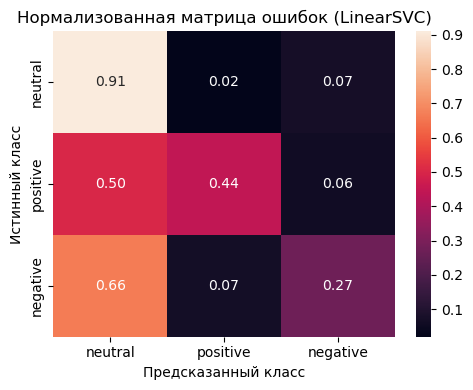

In [15]:
from sklearn.metrics import confusion_matrix

best_name = results_df.iloc[0]["model"]
best_model = models[best_name]

print("Лучшая модель по macro-F1:", best_name)

y_pred_best = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1, 2])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    xticklabels=["neutral", "positive", "negative"],
    yticklabels=["neutral", "positive", "negative"]
)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title(f"Нормализованная матрица ошибок ({best_name})")
plt.tight_layout()
plt.show()


### Основные выводы:
- Класс **neutral** распознаётся лучше всего: более 90% примеров классифицируются корректно.
- Негативные комментарии нередко смешиваются с нейтральными.
- Главная причина — **дисбаланс классов**, где нейтральных сообщений значительно больше остальных.

## 8. Интерпретация модели и анализ значимых признаков

Для лучшей модели (LinearSVC) проанализированы веса признаков TF-IDF,
что позволяет понять, какие слова сильнее всего влияют на классификацию текста.


In [16]:
# Если ещё не выбрали лучшую модель:
best_name = results_df.iloc[0]["model"]
best_model = models[best_name]

print("Лучшая модель:", best_name)

feature_names = np.array(vectorizer.get_feature_names_out())

# Проверяем, что у модели есть coef_ (у MultinomialNB он тоже есть, но его сложнее интерпретировать;
# лучше использовать LogisticRegression или LinearSVC)
print("Форма coef_:", best_model.coef_.shape)  # (n_classes, n_features)

n_top = 20  # сколько слов показывать

for class_idx, class_name in enumerate(["neutral (0)", "positive (1)", "negative (2)"]):
    coefs = best_model.coef_[class_idx]

    top_pos_idx = np.argsort(coefs)[-n_top:][::-1]
    top_neg_idx = np.argsort(coefs)[:n_top]

    print("\n" + "="*80)
    print(f"Класс: {class_name}")
    print("Топ слов с наибольшими положительными весами:")
    for i in top_pos_idx:
        print(f"{feature_names[i]:20s} {coefs[i]:.4f}")

    print("\nТоп слов с наибольшими отрицательными весами (сильнее всего отталкивают от класса):")
    for i in top_neg_idx:
        print(f"{feature_names[i]:20s} {coefs[i]:.4f}")


Лучшая модель: LinearSVC
Форма coef_: (3, 464)

Класс: neutral (0)
Топ слов с наибольшими положительными весами:
стать                1.5152
нива                 1.4402
nfs                  1.3096
день                 1.3058
многие               1.3037
снять                1.1613
нужно                1.1357
версия               1.1334
японский             1.1203
вспомнить            1.0653
база                 1.0598
сильно               1.0546
поднять              0.9922
интересно            0.9631
далёкий              0.9397
топ                  0.8968
мотор                0.8841
выйти                0.8793
хотя                 0.8482
видимость            0.8461

Топ слов с наибольшими отрицательными весами (сильнее всего отталкивают от класса):
хороший              -2.1932
крутой               -2.0113
казаться             -1.9492
супер                -1.9126
класс                -1.8438
идиот                -1.7547
жопа                 -1.6821
москвич              -1.6747
ребята    

### Класс neutral (0)
- Положительные веса: слова описательного характера — «нива», «день», «нужно», «база».
- Отрицательные веса: эмоционально окрашенные слова — «хороший», «самый красивый», «новый».
  
Модель правильно связывает нейтральность с отсутствием выраженной эмоциональности.

### Класс positive (1)
- Сильные положительные маркеры: «класс», «круто», «супер», «отличный», «огонь».
- Сильные отрицательные — слова с жалобами или негативным тоном.

Положительная лексика помогает модели уверенно распознавать позитив.

### Класс negative (2)
- Наиболее выраженные индикаторы негатива: «штраф», «плохой», «ужас», «сломать», «хлам».
- Слова с позитивным значением имеют отрицательный вес.

Модель верно выделяет негативную эмоциональную окраску текста.

### Итог
Интерпретация весов подтверждает адекватность модели:
она опирается на лексические маркеры, которые логично соответствуют каждому классу.

## Заключение

В ходе работы был построен полный конвейер анализа тональности комментариев из сообщества «Автомобильные истории» во ВКонтакте. Реализованы этапы сбора и предобработки данных, автоматической разметки тональности с помощью модели RuBERT, извлечения TF-IDF-признаков и обучения нескольких моделей классификации. Проведён описательный анализ корпуса, выявлен дисбаланс классов и преобладание нейтральных сообщений.

Сравнение моделей показало, что наилучшее качество на отложенной выборке демонстрирует LinearSVC (accuracy около 0.7, наибольший macro-F1), тогда как MultinomialNB и Logistic Regression уступают ей по метрикам, особенно на минорных классах. Анализ матрицы ошибок подтвердил, что модель лучше всего распознаёт нейтральные комментарии и чаще ошибается на границе между позитивом и негативом. Исследование весов признаков показало, что классификатор опирается на ожидаемые лексические маркеры (слова оценочной и эмоциональной окраски), что делает его поведение интерпретируемым. В дальнейшем качество модели можно улучшить за счёт балансировки классов, использования более богатых эмбеддингов и дообучения трансформерных моделей непосредственно на собранном корпусе.


## *Сбалансированная выборка

In [22]:
df.head()

,text,processed_text,sentiment,label,len_chars,len_tokens
0,Полезно,полезно,neutral,0,7,1
1,Админ лось. Форсунка-это датчик?,админ лось форсунка это датчик,negative,2,32,5
2,"На современных авто дмрв не используется, вмес...",современный авто дмрв использоваться вместо дада,neutral,0,57,6
3,"Не датчик, регулятор холостого хода так то ☝",датчик регулятор холостой ход,positive,1,44,4
4,3ууууууууууууууу,ууууууууууууууа,positive,1,16,1


In [18]:
# Разделим данные по классам
neutral_df = df[df["label"] == 0]
positive_df = df[df["label"] == 1]
negative_df = df[df["label"] == 2]

len(neutral_df), len(positive_df), len(negative_df)


(1770, 430, 610)

In [19]:
import pandas as pd

# Обрежем нейтральный класс до 500 случайных примеров
neutral_down = neutral_df.sample(n=500, random_state=42)

# Остальные классы оставляем как есть
balanced_df = pd.concat([neutral_down, positive_df, negative_df], axis=0)

# Перемешиваем строки
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df["label"].value_counts()


label
2    610
0    500
1    430
Name: count, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_bal = balanced_df["processed_text"]
y_bal = balanced_df["label"]

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

vectorizer_bal = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_train_tfidf_bal = vectorizer_bal.fit_transform(X_train_bal)
X_test_tfidf_bal = vectorizer_bal.transform(X_test_bal)

X_train_tfidf_bal.shape, X_test_tfidf_bal.shape


((1232, 241), (308, 241))

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "LinearSVC": LinearSVC()
}

results_bal = []

for name, clf in models.items():
    clf.fit(X_train_tfidf_bal, y_train_bal)
    y_pred_bal = clf.predict(X_test_tfidf_bal)

    acc = accuracy_score(y_test_bal, y_pred_bal)
    f1_macro = f1_score(y_test_bal, y_pred_bal, average="macro")

    results_bal.append({
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro
    })

    print("=" * 80)
    print(f"Модель (сбалансированная выборка): {name}")
    print(classification_report(
        y_test_bal,
        y_pred_bal,
        target_names=["neutral (0)", "positive (1)", "negative (2)"],
        digits=3
    ))

results_bal_df = pd.DataFrame(results_bal).sort_values("f1_macro", ascending=False)
results_bal_df


Модель (сбалансированная выборка): MultinomialNB
              precision    recall  f1-score   support

 neutral (0)      0.476     0.200     0.282       100
positive (1)      0.754     0.535     0.626        86
negative (2)      0.459     0.770     0.575       122

    accuracy                          0.519       308
   macro avg      0.563     0.502     0.494       308
weighted avg      0.547     0.519     0.494       308

Модель (сбалансированная выборка): LogisticRegression
              precision    recall  f1-score   support

 neutral (0)      0.478     0.660     0.555       100
positive (1)      0.714     0.523     0.604        86
negative (2)      0.636     0.557     0.594       122

    accuracy                          0.581       308
   macro avg      0.609     0.580     0.584       308
weighted avg      0.606     0.581     0.584       308

Модель (сбалансированная выборка): LinearSVC
              precision    recall  f1-score   support

 neutral (0)      0.462     0.660  

,model,accuracy,f1_macro
1,LogisticRegression,0.581169,0.584178
2,LinearSVC,0.555195,0.557102
0,MultinomialNB,0.519481,0.494155


##### Эксперимент на сбалансированной выборке

Поскольку исходный датасет имеет выраженный дисбаланс классов (значительное преобладание нейтральных комментариев), был проведён дополнительный эксперимент на искусственно сбалансированной выборке. Для этого нейтральный класс был случайным образом урезан до сопоставимого по размеру с позитивным и негативным (около 100 примеров на класс), после чего выполнили то же разбиение на train/test, построение TF-IDF-признаков и обучение трёх моделей: Multinomial Naive Bayes, Logistic Regression и LinearSVC.

В этих условиях общая точность ожидаемо уменьшилась (до ~0,52–0,58), однако **macro F1-score** стал более информативной метрикой для сравнения методов: вклад каждого класса в итоговую оценку стал примерно равным. На сбалансированной выборке наилучшее качество показывает **логистическая регрессия** (accuracy ≈ 0,58, macro F1 ≈ 0,58), а LinearSVC демонстрирует близкие значения (accuracy ≈ 0,56, macro F1 ≈ 0,56). Это подтверждает, что балансировка классов позволяет получить более честное сравнение моделей анализа тональности.
